In [ ]:
pip install torch torchvision opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 117MB/s]


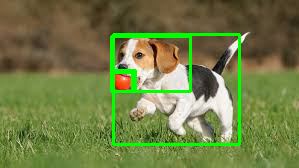

In [ ]:
import torch
import torchvision.transforms as T
import torchvision
import cv2
from google.colab.patches import cv2_imshow

# Load a pre-trained object detection model (e.g., Faster R-CNN)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set to evaluation mode

# Function to draw bounding boxes
def draw_bounding_boxes(image, outputs):
    for box, label, score in zip(outputs['boxes'], outputs['labels'], outputs['scores']):
        if score > 0.5:  # Threshold confidence
            x1, y1, x2, y2 = map(int, box.tolist())
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image

# Function to process and display the image
def process_original_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image_rgb).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image_tensor)[0]

    image_with_boxes = draw_bounding_boxes(image.copy(), outputs)

    cv2_imshow(image_with_boxes)

# Example usage
process_original_image("/content/download.jpg")


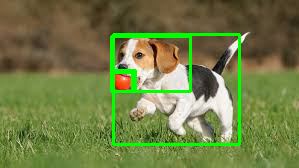

In [ ]:
from google.colab.patches import cv2_imshow

# Process and display the original image with bounding boxes (use cv2_imshow in Colab)
def process_original_image(image_path):
    # Load and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image_rgb)

    # Run the model
    with torch.no_grad():
        outputs = model([image_tensor])[0]

    # Draw bounding boxes
    image_with_boxes = draw_bounding_boxes(image.copy(), outputs)

    # Show image using cv2_imshow in Colab
    cv2_imshow(image_with_boxes)
    # print("Press any key to close the window...")

# Example usage
process_original_image("/content/download.jpg")


Original Image with Bounding Boxes:


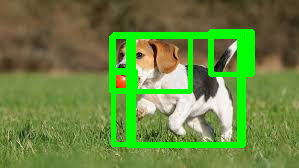

Image with Saliency Overlay:


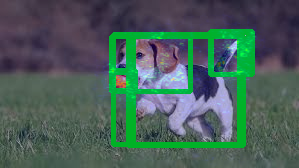

In [ ]:
import cv2
import torch
import numpy as np
from torchvision import models, transforms as T
from google.colab.patches import cv2_imshow

# Load the pre-trained Faster R-CNN model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image_rgb)
    return image, image_rgb, image_tensor

# Generate saliency map using a simple gradient-based approach (guided backprop)
def generate_saliency_map(image_tensor):
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor.requires_grad_()

    # Forward pass through the model
    outputs = model(image_tensor)
    loss = sum([out['scores'].sum() for out in outputs])  # Simple loss function, summing all object scores

    # Backward pass to get gradients
    model.zero_grad()
    loss.backward()

    # Get saliency map (absolute value of gradients)
    saliency_map, _ = torch.max(image_tensor.grad.data.abs(), dim=1)
    saliency_map = saliency_map.squeeze().cpu().numpy()
    saliency_map = cv2.resize(saliency_map, (image_tensor.shape[2], image_tensor.shape[3]))
    return saliency_map

# Draw bounding boxes on the image
def draw_bounding_boxes(image, outputs):
    for box in outputs['boxes']:
        box = box.detach().numpy().astype(int)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 3)
    return image

# Process the image and apply saliency map
def process_saliency_image(image_path):
    # Preprocess the image
    image, image_rgb, image_tensor = preprocess_image(image_path)

    # Generate saliency map
    saliency_map = generate_saliency_map(image_tensor)

    # Run Faster R-CNN on the image
    with torch.no_grad():
        outputs = model([image_tensor])[0]

    # Draw bounding boxes on the image
    image_with_boxes = draw_bounding_boxes(image.copy(), outputs)

    # Normalize the saliency map to be between 0 and 1
    saliency_map = np.uint8(255 * saliency_map)
    saliency_map_colored = cv2.applyColorMap(saliency_map, cv2.COLORMAP_JET)

    # Resize the saliency map to match the original image size
    saliency_map_colored_resized = cv2.resize(saliency_map_colored, (image_with_boxes.shape[1], image_with_boxes.shape[0]))

    # Blend the saliency map with the image
    image_with_saliency = cv2.addWeighted(image_with_boxes, 0.7, saliency_map_colored_resized, 0.3, 0)

    # Show the images
    print("Original Image with Bounding Boxes:")
    cv2_imshow(image_with_boxes)
    print("Image with Saliency Overlay:")
    cv2_imshow(image_with_saliency)

# Example usage
process_saliency_image("/content/download.jpg")
